# The transient Universe - Part 1

### 1)
Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

data = [time, flux, uncertainties] 

In [1]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

In [2]:
data =  np.load('../solutions/transient.npy')
time = data[:,0]
flux = data[:,1]
uncertainties = data[:,2]

Text(0, 0.5, 'flux')

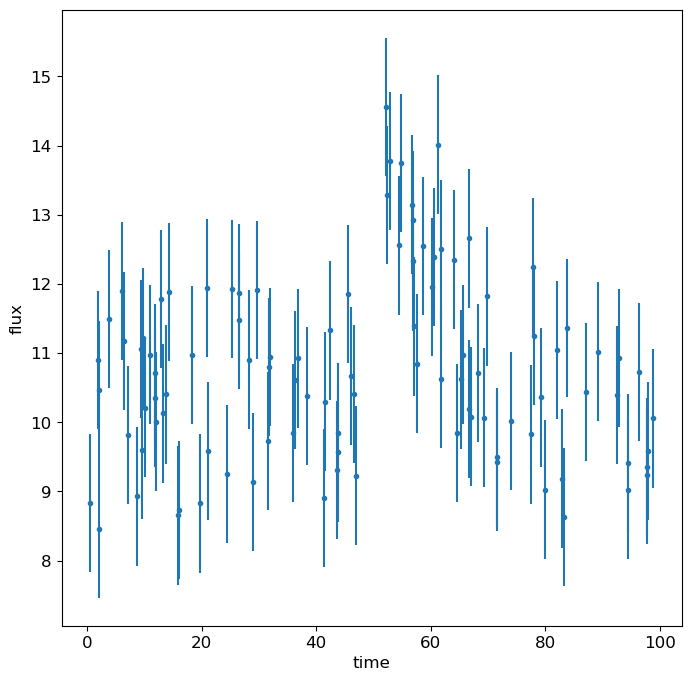

In [3]:
plt.errorbar(time, flux, yerr=uncertainties, fmt=".")
plt.xlabel("time")
plt.ylabel("flux")

### 2) 
One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.*

In [4]:
#Initial parameters
A_in = 5
b_in = 10
t0_in =50
alpha_in = 0.1

@np.vectorize
def model(t,A,b,t_0,alpha):
    t
    if t< t_0:
        return float(b)
    else:
        return float(b+A*np.exp(-alpha*(t-t_0)))

In [5]:
#@np.vectorize
def Initialmodel(theta,t):
    A,b,t_0,alpha = theta
    return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))

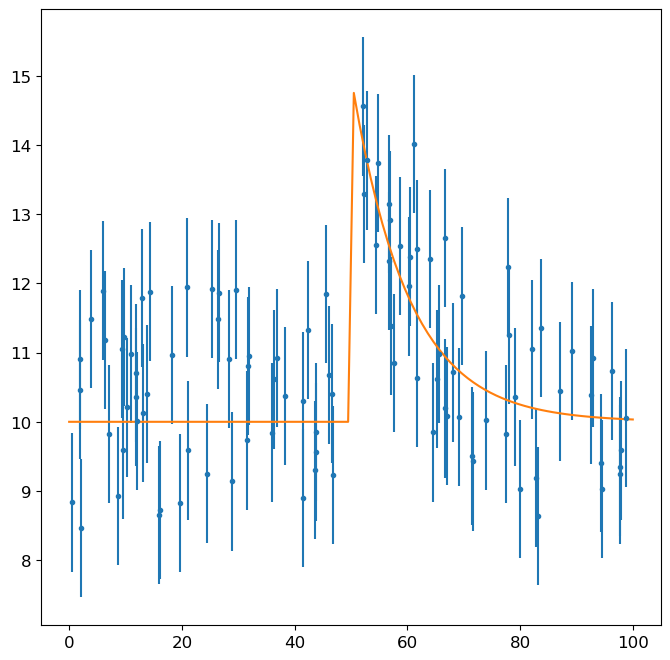

In [6]:

theta_in = np.array([A_in,b_in,t0_in,alpha_in])
xgrid = np.linspace(0,100,100)
ygrid = Initialmodel(theta_in,xgrid)

plt.errorbar(time, flux, yerr=uncertainties, fmt=".")
plt.plot(xgrid,ygrid)

plt.show()

### 3)
Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

In [7]:
import emcee

In [8]:
A_min,A_max, = 0,50
b_min, b_max = 0,50
t0_min, t0_max = 0,100
alpha_min , alpha_max = np.exp(-5),np.exp(5)

In [9]:
#Define all the relevant functions

# y = flux, y_plot = y value from the plot,sigma = error of the data
def loglikelihood(theta,data, model = Initialmodel):
    #x = data[:,0]
    #y= data[:,1]
    #sigma = data[:,2]
    
    y_plot = model(theta,data[:,0])
    return -0.5 * np.sum(((data[:,1]-y_plot)**2)/(data[:,2]**2))
'''
def logprior(theta):
    A,b,t_0,alpha = theta 
    if A_min < A < A_max and b_min < b < b_max and t0_min < t_0 < t0_max and alpha_min < alpha < alpha_max:
        return np.log(np.log(alpha_max/alpha_min))
    else:
      return -np.inf
'''

def logprior(theta):
    A,b,t_0,alpha = theta 
    if A_min < A < A_max and b_min < b < b_max and t0_min < t_0 < t0_max and alpha_min < alpha < alpha_max:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    else:
        return -np.inf

def logposterior(theta,data,model = Initialmodel):
    return loglikelihood(theta,data,model) + logprior(theta) 

In [10]:
ndim = 4 #number of parameter in the model
nwalkers = 20 #number of MCMC walkers
burn = 10000 #burn-in period to let chains stabilize
nsteps = 10000 #number of MCMC steps to take for each walker

starting_guesses = theta_in + 1e-1* np.random.randn(nwalkers, ndim)
print(starting_guesses.shape)

(20, 4)


In [11]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior,args = [data,Initialmodel])
sampler.run_mcmc(starting_guesses,nsteps)

C:\Users\utente\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[ 4.38767115 10.44716931 50.69511404  0.15509795]
 [ 5.26246865 10.11421638 49.04456838  0.09559648]
 [ 5.76420672 10.61820194 49.70811186  0.17003704]
 [ 7.63272821 10.26580601 47.07221836  0.12685924]
 [ 6.16212436 10.36256577 48.54892291  0.13495831]
 [10.98567876 10.23435652 48.17185676  0.17708745]
 [ 9.56413047 10.36182315 46.94167067  0.16026182]
 [ 3.8449713  10.31483616 52.07880452  0.1176328 ]
 [ 5.45113326 10.16582554 48.30068817  0.10138752]
 [ 4.76818489 10.22775655 49.68381563  0.11113037]
 [ 4.80048093 10.33982672 50.51794192  0.14021227]
 [ 8.61971073 10.22082749 47.98623093  0.160219  ]
 [ 3.76163314 10.52945195 50.81216845  0.09264392]
 [ 9.26042273 10.2643296  47.23615787  0.13798582]
 [ 5.26133688 10.20854891 49.6124462   0.12848472]
 [ 8.18469323 10.21771717 47.20798946  0.12784762]
 [ 7.55726002 10.32481713 47.5911322   0.14201655]
 [ 4.98096413 10.37492553 50.17802225  0.1726854 ]
 [ 6.23437289 10.17182944 48.75636693  0.12803284]
 [ 4.71215477 10.29138108

### 4) 
Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

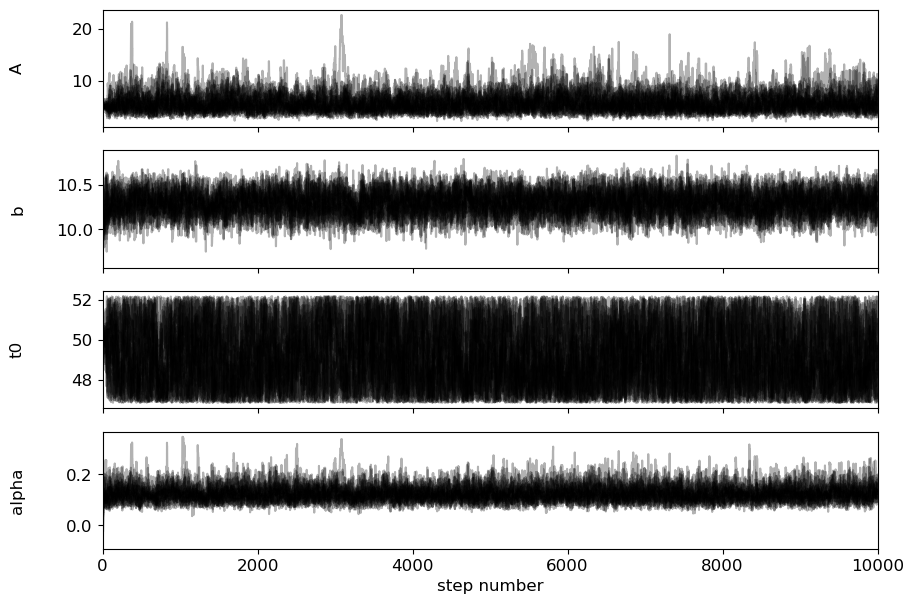

In [12]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### 5) 
Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.


In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[69.41890412 58.38928038 74.72397816 61.09356035]


In [14]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(13200, 4)


C:\Users\utente\anaconda3\lib\site-packages\arviz\data\base.py:221: UserWarning: More chains (10000) than draws (20). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


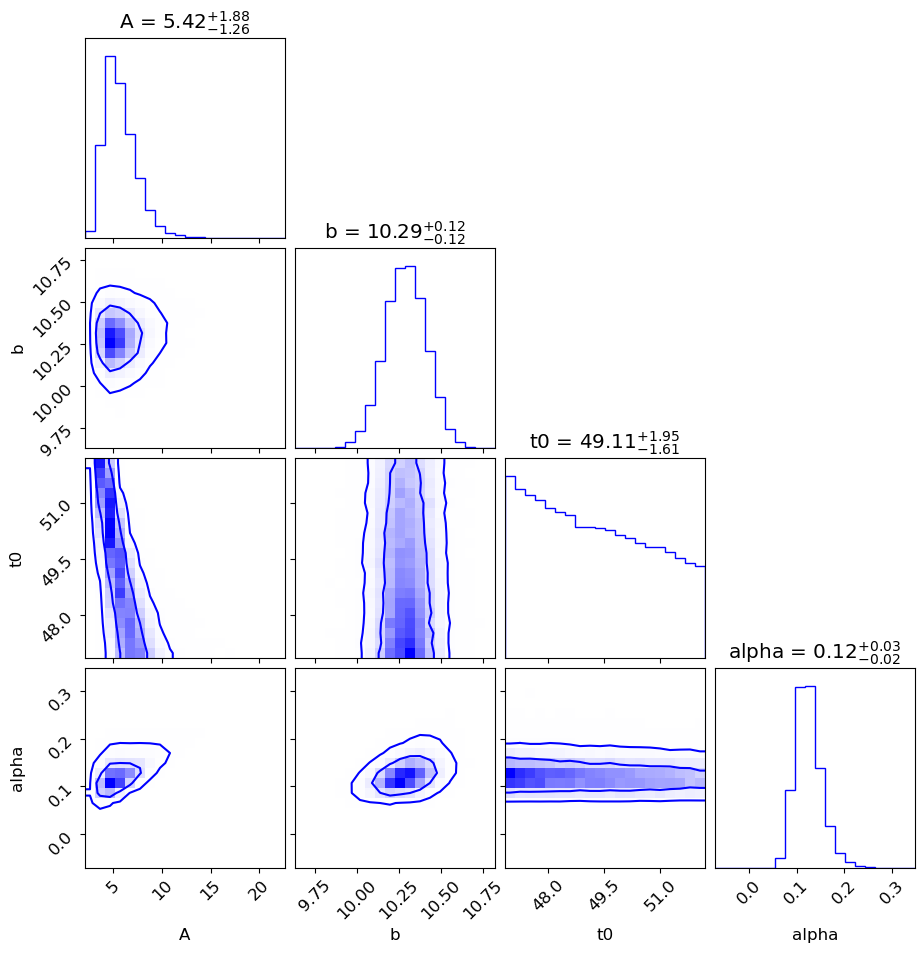

In [15]:
import corner
figure = corner.corner(samples,labels = labels, divergences=True, levels=[0.68,0.95], color='blue', plot_datapoints=False, show_titles=True)

plt.show()

### 6)
Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

<ErrorbarContainer object of 3 artists>

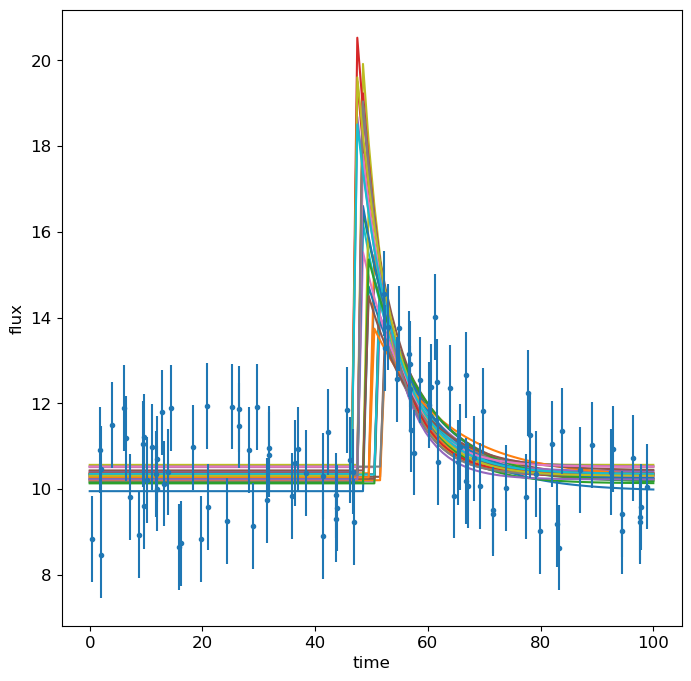

In [16]:
chosen_samples = flat_samples[np.random.choice(len(flat_samples),size=30)]

tgrid = np.linspace(0,100,100)

for chosen_theta in chosen_samples:
    y_plot = Initialmodel(chosen_theta,tgrid)
    plt.plot(tgrid,y_plot)

plt.xlabel("time")
plt.ylabel("flux")
plt.errorbar(time, flux, yerr=uncertainties, fmt=".")

### 7) 
For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance,  $t_0=X^{+Y}_{-Z}$ 

In [17]:
from IPython.display import display, Math

for i,l in enumerate(labels):
    mcmc = np.percentile(flat_samples[:, i], [25,50,75])
    q=np.diff(mcmc)
    print(l+"   "+str(mcmc[1])+" +"+str(q[0])+" -"+str(q[1]))

A   5.427839854472635 +0.9245159793243092 -1.2217386322629071
b   10.292199698163826 +0.08300979721354196 -0.08312899955097741
t0   49.0858677931275 +1.200729355740755 -1.433882389417164
alpha   0.12190110007600201 +0.016420180043266314 -0.018384226722867394
